In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb
from functools import partial
import os
import gc
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

In [2]:
df_trans=pd.read_csv(os.path.join(os.getcwd(),'data/fraud_detection/train_transaction.csv'))
df_id=pd.read_csv(os.path.join(os.getcwd(),'data/fraud_detection/train_identity.csv'))

In [103]:
df_train=df_trans.merge(df_id,how='left',left_on=['TransactionID'],right_on=['TransactionID'])

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def calcoutliers(df_num):
    data_mean,data_std = np.mean(df_num),np.std(df_num)
    
    cut =data_std*3
    lower,upper = data_mean - cut, data_mean+cut
    
    outliers_lower =[x for x in df_num if x <lower]
    outliers_higher =[x for x in df_num if x >upper]
    outliers_total =[x for x in df_num if x <lower or x >upper]
    
    outlier_removed=[x for x in df_num if x >lower and x <upper]
    print('Lowest outliers: %d'%len(outliers_lower))
    print('Upper outliers: %d'%len(outliers_higher))
    print('Total outliers: %d'%len(outliers_total))
    print('Non-outliers observation: %d'%len(outlier_removed))
    print('Total percentage of outliers:{}'.format(round((len(outliers_total)/len(outlier_removed))*100,4)))
    return 

In [42]:
resumetable(df_trans)[:25]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int64,0,2,0,0,0,0.22
2,TransactionDT,int64,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float64,0,20902,68.5,29,59,8.35
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int64,0,13553,13926,2755,4663,9.97
6,card2,float64,8933,500,NaN,404,490,6.32
7,card3,float64,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float64,4259,119,142,102,166,2.66


In [3]:
df_trans['TransactionAmt']=df_trans.TransactionAmt
total=len(df_trans)
total_amt=df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()

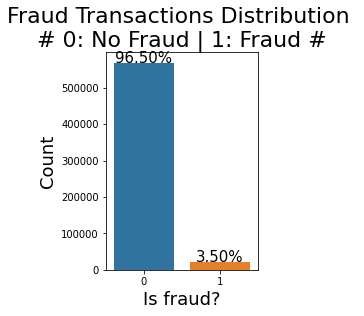

In [68]:
plt.subplot(121)
g=sns.countplot(x='isFraud',data=df_trans)
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,height+3,'{:1.2f}%'.format(height/total*100),
          ha='center',fontsize=15)


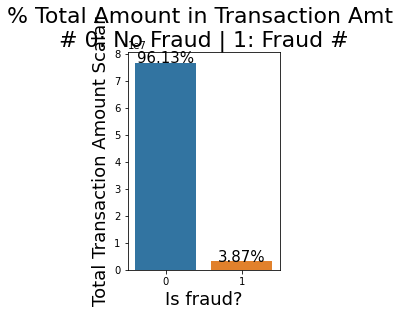

In [69]:
perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    

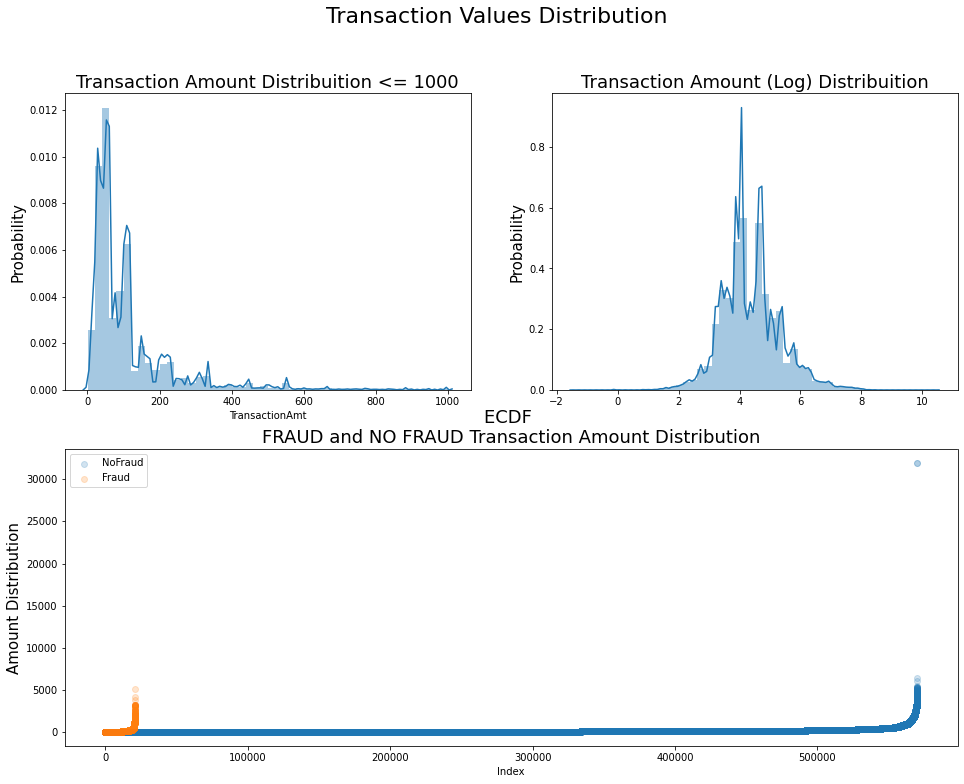

In [30]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution',fontsize=22)
plt.subplot(221)
g=sns.distplot(df_trans[df_trans.TransactionAmt<1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_ylabel('Probability',fontsize=15)
plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)
plt.subplot(212)
g4=plt.scatter(range(df_trans[df_trans['isFraud']==0].shape[0]),
                np.sort(df_trans[df_trans['isFraud']==0]['TransactionAmt']),label='NoFraud',alpha=.2)
g4=plt.scatter(range(df_trans[df_trans['isFraud']==1].shape[0]),
              np.sort(df_trans[df_trans['isFraud']==1]['TransactionAmt']),label='Fraud',alpha=.2
              )
g4=plt.title('ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution',fontsize=18)
g4=plt.xlabel('Index')
g4=plt.ylabel("Amount Distribution", fontsize=15)
g4=plt.legend()

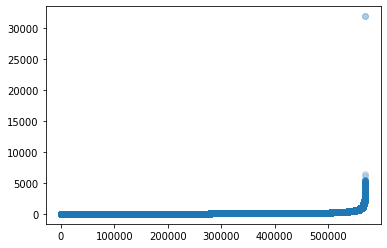

In [27]:

plt.scatter(range(df_trans[df_trans['isFraud']==0].shape[0]),
                np.sort(df_trans[df_trans['isFraud']==0]['TransactionAmt']),label='NoFraud',alpha=.2)

In [10]:
pd.concat([df_trans[df_trans['isFraud']==1]['TransactionAmt']\
.quantile([0.01,.1,.25,.5,.75,.9,.99])\
.reset_index(),df_trans[df_trans['isFraud']==0]['TransactionAmt']\
.quantile([0.01,.1,.25,.5,.75,.9,.99])\
.reset_index()],axis=1,keys=['Fraud','No Fraud'])

Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01        6.74096     0.01        9.51288
1  0.10       18.93600     0.10       26.31000
2  0.25       35.04400     0.25       43.97000
3  0.50       75.00000     0.50       68.50000
4  0.75      161.00000     0.75      120.00000
5  0.90      335.00000     0.90      267.11200
6  0.99      994.00000     0.99     1104.00000

In [25]:
calcoutliers(df_trans.TransactionAmt)

Lowest outliers: 0
Upper outliers: 10093
Total outliers: 10093
Non-outliers observation: 580447
Total percentage of outliers:1.7388


In [36]:
## normalize over each row
tmp=pd.crosstab(df_trans['ProductCD'],df_trans['isFraud'],normalize='index')
tmp=tmp.reset_index()
tmp.rename(columns={0:'NoFraud',1:'Fraud'},inplace=True)

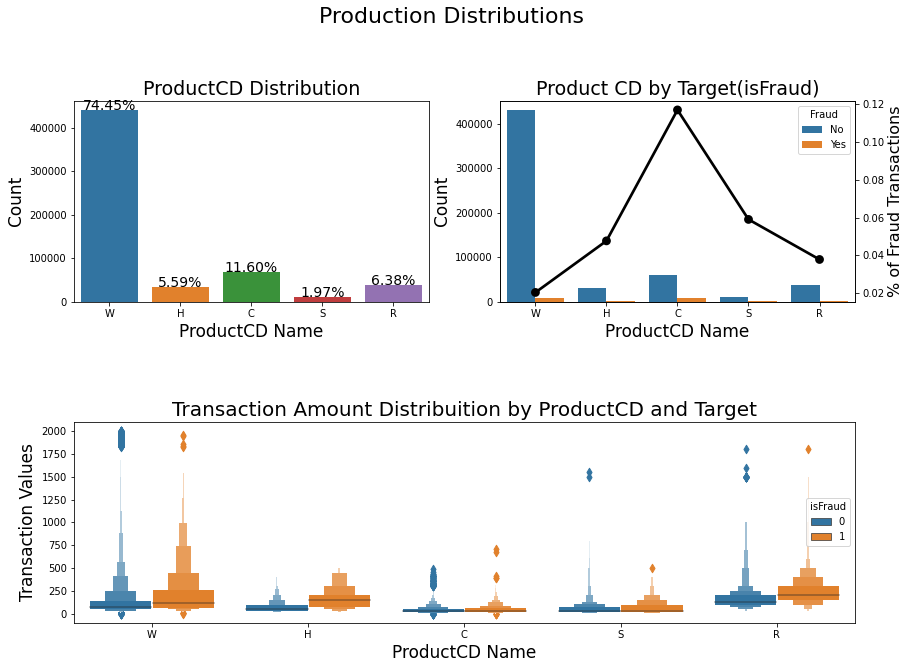

In [65]:
plt.figure(figsize=(14,10))
plt.suptitle('Production Distributions',fontsize=22)
plt.subplot(221)
g=sns.countplot(x='ProductCD',data=df_trans)
g.set_title('ProductCD Distribution',fontsize=19)
g.set_xlabel('ProductCD Name',fontsize=17)
g.set_ylabel('Count',fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
plt.subplot(222)
g1=sns.countplot(x='ProductCD',hue='isFraud',data=df_trans)
plt.legend(title='Fraud',loc='best',labels=['No','Yes'])
gt=g1.twinx()
gt=sns.pointplot(x='ProductCD',y='Fraud',data=tmp,color='black',
              order=['W', 'H',"C", "S", "R"])
gt.set_ylabel('% of Fraud Transactions',fontsize=16)
g1.set_title('Product CD by Target(isFraud)',fontsize=19)
g1.set_xlabel('ProductCD Name',fontsize=17)
g1.set_ylabel('Count',fontsize=17)
plt.subplot(212)
g3=sns.boxenplot(x='ProductCD',y='TransactionAmt',hue='isFraud',
           data=df_trans[df_trans['TransactionAmt']<=2000])
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)
plt.subplots_adjust(hspace=0.6,top=0.85)

In [77]:
df_trans[['card1','card2','card3','card4','card5','card6']].quantile([.01,0.025,.1,.25,.5,.75,.975,.99])

,card1,card2,card3,card5
0.010,1338.0,100.0,144.0,102.0
0.025,1675.0,111.0,150.0,102.0
0.100,2803.0,111.0,150.0,126.0
0.250,6019.0,214.0,150.0,166.0
0.500,9678.0,361.0,150.0,226.0
0.750,14184.0,512.0,150.0,226.0
0.975,18018.0,583.0,185.0,226.0
0.990,18238.0,583.0,185.0,226.0


In [12]:
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts()<200].index),'card3']='Others'
df_trans.loc[df_trans.card5.isin(df_trans.card5.value_counts()[df_trans.card5.value_counts()<300].index),'card5']='Others'

In [18]:
tmp=pd.crosstab(df_trans['card3'],df_trans['isFraud'],normalize='index').reset_index()
tmp.rename(columns={0:'NoFraud',1:'Fraud'},inplace=True)
tmp2=pd.crosstab(df_trans['card5'],df_trans['isFraud'],normalize='index').reset_index()
tmp2.rename(columns={0:'NoFraud',1:'Fraud'},inplace=True)

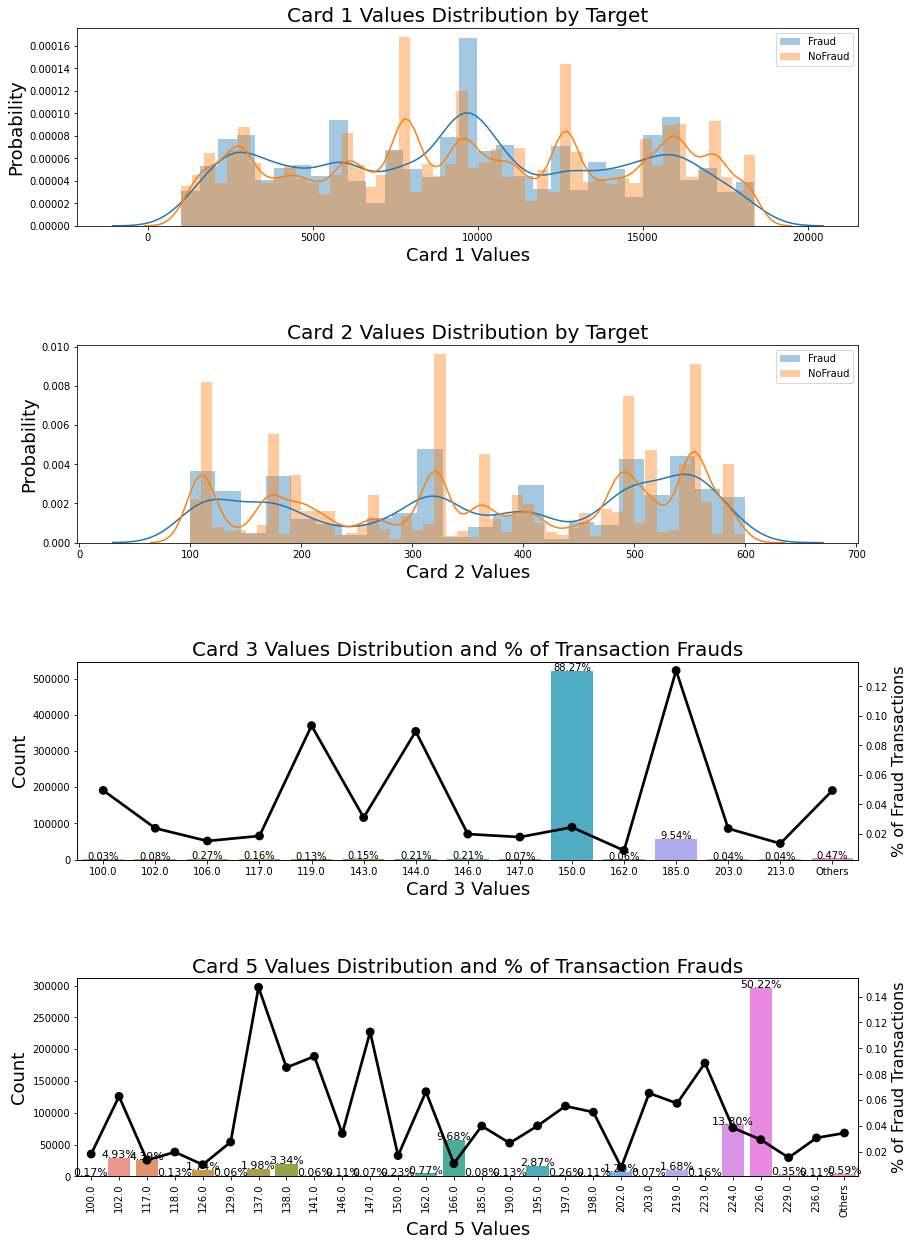

In [38]:
plt.figure(figsize=(14,22))
plt.subplot(411)
g=sns.distplot(df_trans[df_trans['isFraud']==1]['card1'],label='Fraud')
g=sns.distplot(df_trans[df_trans['isFraud']==0]['card1'],label='NoFraud')
g.legend()
g.set_title('Card 1 Values Distribution by Target',fontsize=20)
g.set_xlabel('Card 1 Values',fontsize=18)
g.set_ylabel('Probability',fontsize=18)
plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)
plt.subplot(413)
g2=sns.countplot(x='card3',data=df_trans,order=list(tmp.card3.values))
g22=g2.twinx()
gg2=sns.pointplot(x='card3',y='Fraud',data=tmp,color='black',
              order=list(tmp.card3.values))
gg2.set_ylabel('% of Fraud Transactions',fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)

In [44]:
tmp=pd.crosstab(df_trans['card4'],df_trans['isFraud'],normalize='index')*100
tmp.reset_index(inplace=True)
tmp.rename(columns={0:'NoFraud',1:'Fraud'},inplace=True)

In [48]:
plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions',fontsize=22)
plt.subplot(221)


isFraud,card4,NoFraud,Fraud
0,american express,97.130163,2.869837
1,discover,92.271839,7.728161
2,mastercard,96.566905,3.433095
3,visa,96.524390,3.475610


Text(0, 0.5, 'Count')

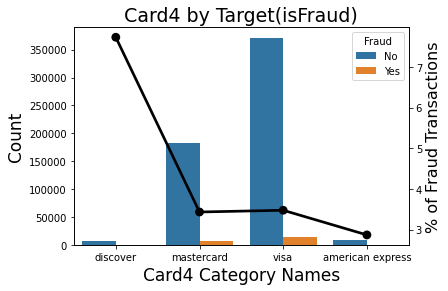

In [54]:
g1=sns.countplot(x='card4',hue='isFraud',data=df_trans)
plt.legend(title='Fraud',loc='best',labels=['No','Yes'])
gt=g1.twinx()
sns.pointplot(x='card4',y='Fraud',data=tmp,color='black',legend=False,
              order=['discover','mastercard','visa','american express'])
gt.set_ylabel('% of Fraud Transactions',fontsize=16)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

In [55]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    df_trans[col] = df_trans[col].fillna('Miss')

In [7]:
df_trans.loc[df_trans['P_emaildomain'].isin(['gmail.com','gmail']),'P_emaildomain']='Google'

df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans['P_emaildomain'].isin(df_trans['P_emaildomain'].value_counts()\
                                            [df_trans['P_emaildomain'].value_counts()<=500].index),'P_emaildomain']='Others'
df_trans['P_emaildomain'].fillna('NoInf',inplace=True)

Text(0, 0.5, '%Fraud Transactions')

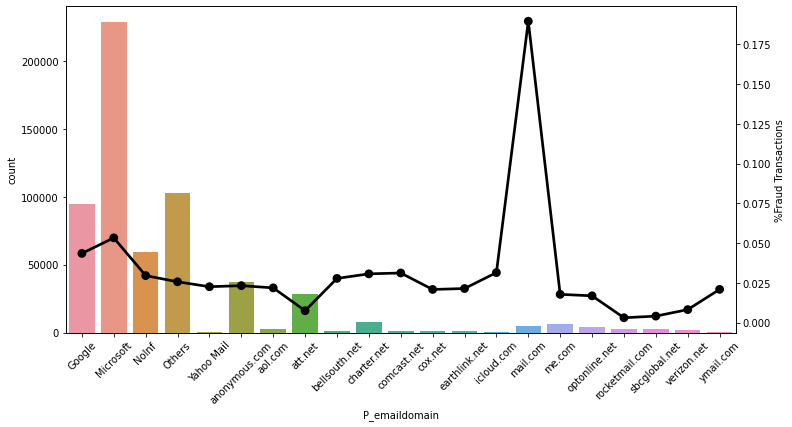

In [41]:
plt.figure(figsize=(12,6))
g=sns.countplot(x='P_emaildomain',data=df_trans)
plt.xticks(rotation=45)
tmp=pd.crosstab(df_trans['P_emaildomain'],df_trans['isFraud'],normalize='index').reset_index()
tmp.rename(columns={0:'NoFraud',1:'Fraud'},inplace=True)
gt=g.twinx()
sns.pointplot(x='P_emaildomain',y='Fraud',data=tmp,order=list(tmp['P_emaildomain']),color='black')
gt.set_ylabel('%Fraud Transactions')

In [73]:
df_trans['date']=df_trans.TransactionDT.apply(lambda x:(startdate+datetime.timedelta(seconds=x)))

In [77]:
df_trans['weekday']=df_trans.date.apply(lambda x:pd.Timestamp(x).weekday())
df_trans['hours']=df_trans.date.apply(lambda x:pd.Timestamp(x).hour)
df_trans['day']=df_trans.date.apply(lambda x:pd.Timestamp(x).day)

In [99]:
df_id

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [120]:
df_train.loc[df_train['id_30'].str.contains('Windows',na=False),'id_30']='Windows'
df_train.loc[df_train['id_30'].str.contains('iOS',na=False),'id_30']='iOS'
df_train.loc[df_train['id_30'].str.contains('Mac OS',na=False),'id_30']='Mac'
df_train.loc[df_train['id_30'].str.contains('Android',na=False),'id_30']='Android'
df_train['id_30'].fillna('NAN',inplace=True)
df_train.loc[df_train['id_31'].str.contains('chrome',na=False),'id_31']='Chrome'
df_train.loc[df_train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df_train.loc[df_train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df_train.loc[df_train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df_train.loc[df_train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df_train.loc[df_train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df_train.loc[df_train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
df_train['id_31'].fillna("NAN", inplace=True)
df_train.loc[df_train.id_31.isin(df_train.id_31.value_counts()[df_train.id_31.value_counts()<200].index),'id_31']='Others'

## Modelling 